In [14]:
import tensorflow as tf
import numpy as np
import pickle,pdb,sys,itertools,random
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from google.colab import files
import pylab as pl
from keras.datasets import cifar10
from glob import glob

In [81]:
try: sess.close()
except: pass
tf.reset_default_graph()

In [102]:
#def CreateModel1(nFilts=64,nHidden=512,nClasses=10,dropRate=.2):

nFilts=64
nHidden=512

# Inputs and outputs
x=tf.placeholder(tf.float32,[None,32,32,3],name='x')
y=tf.placeholder(tf.float32,[None,10],name='y')
kp=tf.placeholder(tf.float32,(),name='kp')

w1=tf.Variable(tf.truncated_normal([3,3,3,nFilts],stddev=.01),name='w1')
a1=tf.nn.conv2d(x,w1,(1,1,1,1),padding='VALID')
a1=tf.nn.relu(tf.nn.max_pool(a1,(1,3,3,1),strides=(1,2,2,1),padding='VALID'))
a1=tf.nn.dropout(a1,kp,name='a1')

w2=tf.Variable(tf.truncated_normal([3,3,3,nFilts*2],stddev=.01),name='w2')
a2=tf.nn.conv2d(x,w1,(1,1,1,1),padding='VALID')
a2=tf.nn.relu(tf.nn.max_pool(a2,(1,3,3,1),strides=(1,2,2,1),padding='VALID'))
a2=tf.nn.dropout(a2,kp,name='a2')

# Fully connected layers
d=np.prod(a2.get_shape().as_list()[1:])
reshaped=tf.reshape(a2,(-1,d))

w3=tf.Variable(tf.truncated_normal((d,nHidden),stddev=.01),dtype=tf.float32,name='w3')
b3=tf.Variable(tf.zeros(nHidden,),dtype=tf.float32,name='b3')
a3=tf.nn.relu(tf.matmul(reshaped,w3)+b3)
a3=tf.nn.dropout(a3,kp,name='a3')

w4=tf.Variable(tf.truncated_normal((nHidden,10),stddev=.01),dtype=tf.float32,name='w4')
b4=tf.Variable(tf.zeros(10,),dtype=tf.float32,name='b4')
a4=tf.add(tf.matmul(a3,w4),b4,name='a4')
yhat=tf.nn.softmax(a4,name='yhat')

In [17]:
# Creating the datasets

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train=(x_train/255.)-.5
x_test=(x_test/255.)-.5

ty=OneHotEncoder().fit_transform(y_train)

In [82]:
# Params
batchSize=128
keepProb=.8
learnRate=.0005
nIters=10000
alpha=.1
pVal=.02 # Proportion set aside for validation while training

# Adjust regularization
alpha=0.0
beta=0.0
keepProb=.5

# curve=tf.gradients(a4,x) <- original... doesn't square the gradients
grady=[tf.gradients(a4[:,tmp],x,name='grad'+str(tmp))[0] for tmp in range(10)]
curves=[tf.pow(tf.gradients(a4[:,tmp],x)[0],2) for tmp in range(10)]
curveloss=1000*tf.reduce_mean(curves)
l2loss=tf.nn.l2_loss(w1)+tf.nn.l2_loss(w2)+tf.nn.l2_loss(w3)+tf.nn.l2_loss(b3)+tf.nn.l2_loss(w4)+tf.nn.l2_loss(b4)

loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=a4))+beta*l2loss
opt=tf.train.AdamOptimizer(learning_rate=learnRate).minimize((1-alpha)*loss+alpha*curveloss)
acc=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(a4,1),tf.argmax(y,1)),tf.float32))

try:
  sess.close()
except:
  pass

sess=tf.Session()
sess.run(tf.global_variables_initializer())


ValueError: ignored

In [19]:
# Splitting into training and validation sets

validationInstances=np.random.rand(len(x_train))<pVal
x_train_=x_train[np.logical_not(validationInstances)]
ty_=ty[np.logical_not(validationInstances)].toarray()
valSet=x_train[validationInstances]
valTy=ty[validationInstances].toarray()

In [20]:
trainLosses=[]
valLosses=[]

for count in range(nIters):
  
  batchidx=np.random.choice(range(len(x_train_)),batchSize)
  xbatch=x_train_[batchidx,:,:,:]
  ybatch=ty_[batchidx,:]
  
  _,trainloss,accuracy,closs=sess.run([opt,loss,acc,curveloss],feed_dict={x:xbatch,y:ybatch,kp:keepProb})
  
  if count % 500==0:
    valLoss=sess.run([loss],feed_dict={x:valSet,y:valTy,kp:1.})[0]
    valLosses.append(valLoss)
    trainLosses.append(trainloss)
    print("Iteration #"+str(count)+", training loss:"+str(trainloss)+", accuracy is "+str(accuracy)+", and curveLoss="+str(closs)+', Validation loss:'+str(valLoss))
    
print("Iteration #"+str(count)+", training loss:"+str(trainloss)+", accuracy is "+str(accuracy))
#sess.close()

Iteration #0, training loss:2.302628, accuracy is 0.078125, and curveLoss=8.8767265e-06, Validation loss:2.3003335
Iteration #500, training loss:1.441421, accuracy is 0.5078125, and curveLoss=0.78416634, Validation loss:1.339436
Iteration #1000, training loss:1.0511813, accuracy is 0.6171875, and curveLoss=1.1660666, Validation loss:1.2332083
Iteration #1500, training loss:1.1105077, accuracy is 0.6640625, and curveLoss=1.2621108, Validation loss:1.1675621
Iteration #2000, training loss:1.0098342, accuracy is 0.6484375, and curveLoss=1.3586792, Validation loss:1.1211375
Iteration #2500, training loss:1.0096327, accuracy is 0.65625, and curveLoss=1.437196, Validation loss:1.0959662
Iteration #3000, training loss:0.88050795, accuracy is 0.7265625, and curveLoss=1.4320335, Validation loss:1.0657855
Iteration #3500, training loss:0.7907704, accuracy is 0.75, and curveLoss=1.5467838, Validation loss:1.0397956
Iteration #4000, training loss:0.8908982, accuracy is 0.703125, and curveLoss=1.58

In [25]:
sampler=pl.rand(len(y_test))<.2

testAcc,testCurveLoss=sess.run([acc,curveloss],feed_dict={x:x_test[sampler],y:OneHotEncoder().fit_transform(y_test[sampler]).toarray(),kp:1})
print("Test accuracy (%):"+str(testAcc)+", Test curveLoss:"+str(testCurveLoss))

# Pre-curveloss: 0.7125

Test accuracy (%):0.697318, Test curveLoss:2.147525


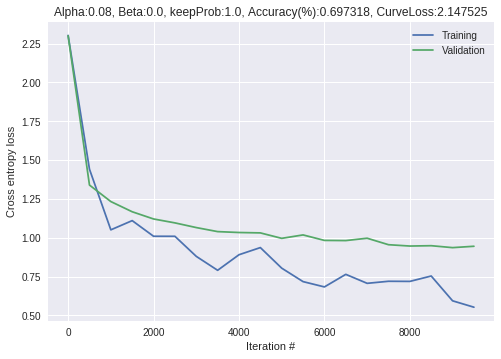

In [26]:
pl.title("Alpha:"+str(alpha)+", Beta:"+str(beta)+", keepProb:"+str(keepProb)+", Accuracy(%):"+str(testAcc)+", CurveLoss:"+str(testCurveLoss))
pl.plot(range(0,10000,500),trainLosses)
pl.plot(range(0,10000,500),valLosses)
pl.xlabel('Iteration #')
pl.ylabel('Cross entropy loss')
pl.legend(["Training","Validation"])

In [35]:
# Save the model
saver=tf.train.Saver()
saver.save(sess,"./"+"alpha:"+str(alpha)+"-beta:"+str(beta)+"-keepProb:"+str(keepProb))
#saver.save(sess,"./model1")

'./alpha:0.08-beta:0.0-keepProb:1.0'

In [108]:
files.download("model1.data-00000-of-00001")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 56386, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [107]:
!ls -lh

total 186M
-rw-r--r-- 1 root root  74M Jul 12 20:49 alpha:0.08-beta:0.0-keepProb:1.0.data-00000-of-00001
-rw-r--r-- 1 root root  735 Jul 12 20:49 alpha:0.08-beta:0.0-keepProb:1.0.index
-rw-r--r-- 1 root root 1.1M Jul 12 20:49 alpha:0.08-beta:0.0-keepProb:1.0.meta
-rw-r--r-- 1 root root  121 Jul 12 20:49 checkpoint
drwxr-xr-x 3 root root 4.0K Jul 11 16:53 datalab
-rw-r--r-- 1 root root  37M Jul 12 21:30 model1 (1).data-00000-of-00001
-rw-r--r-- 1 root root  74M Jul 12 20:48 model1.data-00000-of-00001
-rw-r--r-- 1 root root  735 Jul 12 20:48 model1.index
-rw-r--r-- 1 root root 1.1M Jul 12 20:48 model1.meta
